#Preprocessing

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/My Drive/HW5/training.csv')
df=df.drop(columns='level_0')

In [ ]:
test=pd.read_csv('/content/drive/My Drive/HW5/test.csv')

test=test.drop(columns='level_0')

In [ ]:
# most of the code below was also done in HW4

df['productGroup']=df['productGroup'].fillna(17)   
df['rrp']=df['rrp'].fillna(0)
df['productGroup']=df['productGroup'].astype('int')

In [ ]:
df['productGroup_risk']=df['productGroup'].apply(lambda a: 0 if a in (14,15,17) else (1 if a in (2,12) else (4 if a in (0,6,9,16) else 3)))

# to avoid using dummy encoding on this feature, which would create 19 columns, i rather used my results from hw4 to divide the productGroups in risk groups, 
# depended on the proportion they were returned(e.g. 14 and 15 had an average return rate below 0.15). Now we have an ordinal structure here. 

In [ ]:
df_order = df[['orderID','quantity','price','returned']].groupby(['orderID'],as_index=False).sum()
order_voucherdict = dict(zip(df['orderID'],df['voucherAmount']))      
df_order['voucherAmount'] = df_order['orderID'].map(order_voucherdict)    # the voucher amount that was used in each order

In [ ]:
order_customer_dict = dict(zip(df['orderID'],df['customerID']))  # pairing each orderid with the customerid
df_order['customerID']=df_order['orderID'].map(order_customer_dict) 

In [ ]:
df_order['number_of_orders']=1
df_order['used_voucher']=df_order['voucherAmount'].apply(lambda x: 1 if x > 0 else 0 )    # creates a boolean column

In [ ]:
df_customer1=df_order.drop(columns=['orderID']).groupby('customerID').sum()

In [ ]:
df_customer2=df_order.drop(columns=['orderID']).groupby('customerID').mean()

In [ ]:
df_customer2['number_of_orders']=df_customer1['number_of_orders']   # add the total number of orders to the DF which contains the mean values of the other features

In [ ]:
avg_return_rate_dict=dict(zip(df_customer2.index,df_customer2['returned']))  # give each customer a rating corresponding to the amount of returns in average

In [ ]:
df['customer_return_rate']=df['customerID'].map(avg_return_rate_dict)     # these are the average returns a customer has made for each order, this helps us to identify customers who return a lot of articles

In [ ]:
df_article=df[['returned','articleID']].groupby(['articleID']).mean()   
df_article['article_risk']=df_article['returned'].apply(lambda x: 0 if x <= 0.46 else (1 if 0.46 < x <=0.54 else ( 2 if 0.54 < x <=0.64 else 3 )  ))
article_dict=dict(zip(df_article.index,df_article.article_risk))        # some articles have a higher return rate, this helps the classifier to identify potential returns 

#Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df_customer3=df_customer2[['price','used_voucher']]       
df_customer3['number_of_orders']=df_customer1['number_of_orders']       # these are the three features i use to cluster the customers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_customer3

,price,used_voucher,number_of_orders
customerID,,,
0,38.136190,0.015873,63
1,69.656667,0.000000,6
2,112.980000,1.000000,1
3,59.985000,0.000000,2
4,92.502000,0.120000,25
...,...,...,...
49994,279.980000,0.000000,1
49995,164.970000,1.000000,1
49996,39.990000,0.000000,1


In [ ]:
from sklearn.preprocessing import StandardScaler      # first i scale the data to improve the clustering process
ssc=StandardScaler()
ssc.fit(df_customer3)
StandardScaler(copy=True,with_mean=True,with_std=True)
df_customer3_scaled=ssc.transform(df_customer3)

In [ ]:
WCSSE=[]

# this helps us to identify the ideal value for k in Kmeans
K=range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k)       
    
    kmeanModel.fit(df_customer3_scaled)
    WCSSE.append(kmeanModel.inertia_)

In [ ]:
import matplotlib.pyplot as plt


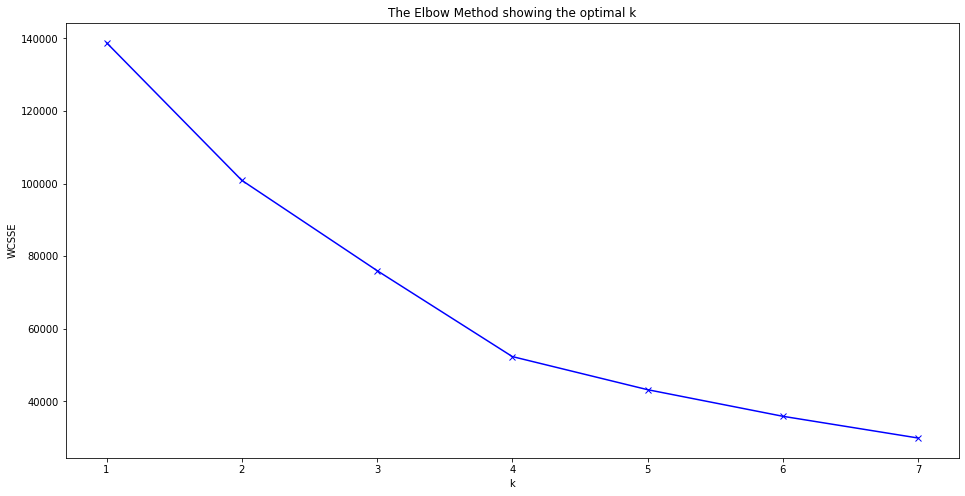

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, WCSSE, 'bx-',color='blue')
plt.xlabel('k')
plt.ylabel('WCSSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# as we can see below 4 clusters is a good value for k

In [ ]:
kmeans=KMeans(4)
kmeans.fit(df_customer3_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
import seaborn as sns

In [ ]:
df_customer3['cluster']=kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:

for i in range(4) :
 print(sum(kmeans.labels_==i))
  

28543
9778
1390
6571


In [ ]:
pd.DataFrame(kmeans.cluster_centers_,columns=['price','orders','voucher'])

,price,orders,voucher
0,-0.355248,-0.488874,-0.086517
1,-0.170152,1.678932,-0.227885
2,-0.128590,-0.289542,4.213831
3,1.823183,-0.313556,-0.176445


Cluster 0: These are the non regular customers who don't spend much. They all have less than 25 total orders, and all of these orders contained articles which cost less than ~100 Euro. They usually won't use many vouchers.

Cluster 1: These customers also have a low amount of orders, but they spent much more per article in average. This cluster contains a high variance in using vouchers.

Cluster 2: These are similiar to the cluster 0 with the only differnce thaht they use a lot of vouchers on average.

Cluster 3: cluster 3 contains the regular customers, they all have more than 23/24 orders. Thex spent much money per article and usually wont't use vouchers. 

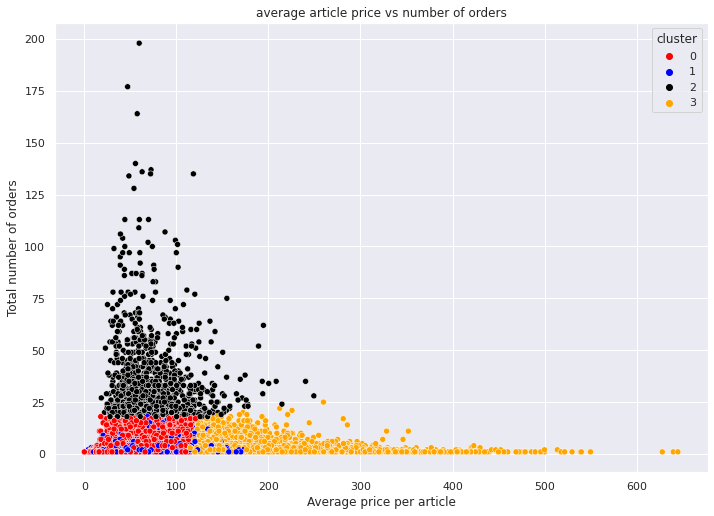

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='price',y='number_of_orders',data=df_customer3, hue='cluster',palette=['red','blue','black','orange'])
plt.xlabel('Average price per article')
plt.ylabel('Total number of orders')
plt.title('average article price vs number of orders')
plt.show()

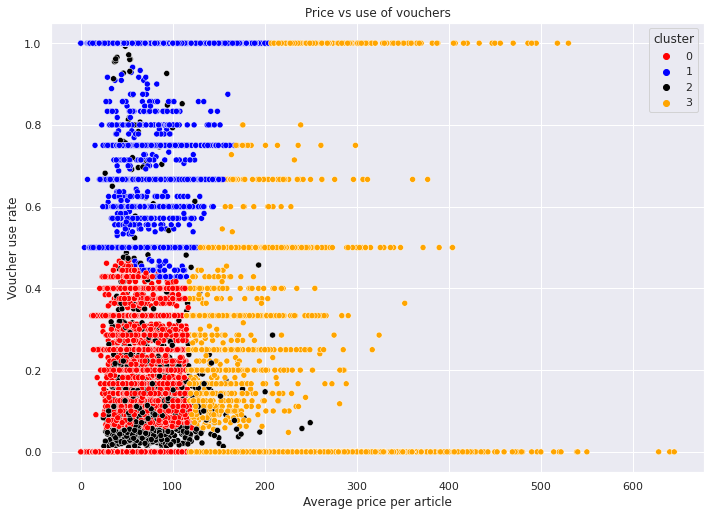

In [ ]:
sns.scatterplot(x='price',y='used_voucher',data=df_customer3, hue='cluster',palette=['red','blue','black','orange'])
plt.xlabel('Average price per article')
plt.ylabel('Voucher use rate')
plt.title('Price vs use of vouchers')
plt.show()

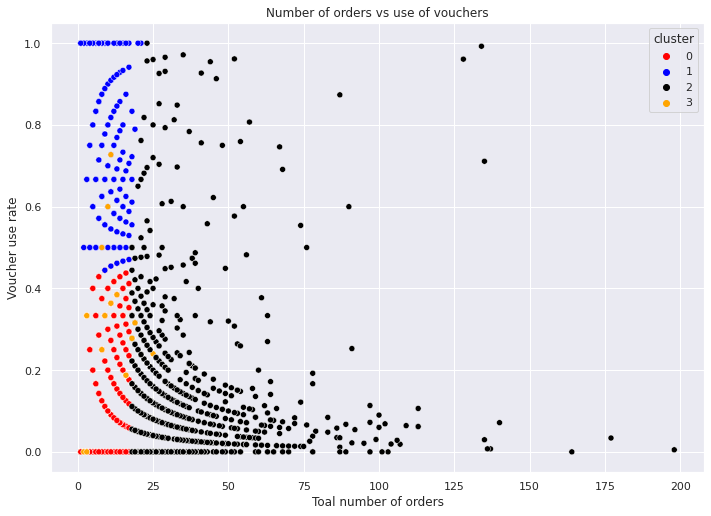

In [ ]:
sns.scatterplot(x='number_of_orders',y='used_voucher',data=df_customer3, hue='cluster',palette=['red','blue','black','orange'])
plt.title('Number of orders vs use of vouchers')
plt.ylabel('Voucher use rate')
plt.xlabel('Toal number of orders')
plt.show() 

In [ ]:
order_dict=dict(zip(df_customer3.index,df_customer3['cluster']))
df['cluster']=df['customerID'].map(order_dict)  

#More feature engineering

In [ ]:
order_total_dict=dict(zip(df_order['orderID'],df_order['price']))
order_total_dict=dict(zip(df_order['orderID'],df_order['price']))

In [ ]:
df['order_total']=df['orderID'].map(order_total_dict)         #the total value of the order in which the article was bought, since a high order price leads to high number return, a higher price indicated an increased probability for returning an article 
df['proportion_of_total']=(df['price']+0.01)/(df['order_total']+0.01)  #the proportion this article has in the total order, 
df['voucher_proportion']=(df['voucherAmount']+0.01)/(df['order_total']+0.01)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Id                    400000 non-null  int64  
 1   orderID               400000 non-null  int64  
 2   articleID             400000 non-null  int64  
 3   colorCode             400000 non-null  int64  
 4   sizeCode              400000 non-null  int64  
 5   productGroup          400000 non-null  int64  
 6   quantity              400000 non-null  int64  
 7   price                 400000 non-null  float64
 8   rrp                   400000 non-null  float64
 9   voucherID             400000 non-null  float64
 10  voucherAmount         400000 non-null  float64
 11  customerID            400000 non-null  int64  
 12  deviceID              400000 non-null  int64  
 13  paymentMethod         400000 non-null  object 
 14  returned              400000 non-null  int64  
 15  

In [ ]:
#these are the same steps which  was done for the training set

test['productGroup']=test['productGroup'].fillna(17)
test['rrp']=test['rrp'].fillna(0)
test['productGroup']=test['productGroup'].astype('int')
test['productGroup_risk']=test['productGroup'].apply(lambda a: 0 if a in (14,15,17) else (1 if a in (2,12) else (4 if a in (0,6,9,16) else 3)))
test_order = test[['orderID','quantity','price']].groupby(['orderID'],as_index=False).sum()
order_voucherdict = dict(zip(test['orderID'],test['voucherAmount']))
test_order['voucherAmount'] = test_order['orderID'].map(order_voucherdict)
order_customer_dict = dict(zip(test['orderID'],test['customerID']))  # pairing each orderid with the customerid
test_order['customerID']=test_order['orderID'].map(order_customer_dict)
test_order['number_of_orders']=1
test_order['used_voucher']=test_order['voucherAmount'].apply(lambda x: 1 if x > 0 else 0 )
test_customer1=test_order.drop(columns=['orderID']).groupby('customerID').sum()
test_customer2=test_order.drop(columns=['orderID']).groupby('customerID').mean()
test_customer2['number_of_orders']=test_customer1['number_of_orders']


order_total_dict=dict(zip(test_order['orderID'],test_order['price']))
order_total_dict=dict(zip(test_order['orderID'],test_order['price']))
test['order_total']=test['orderID'].map(order_total_dict)
test['proportion_of_total']=(test['price']+0.01)/(test['order_total']+0.01)
test['voucher_proportion']=(test['voucherAmount']+0.01)/(test['order_total']+0.01)

test['customer_return_rate']=test['customerID'].map(avg_return_rate_dict)
test['customer_return_rate']=test['customer_return_rate'].fillna(1.25) # give the new customers a value between the mean and median


In [ ]:
test_order['used_voucher']=test_order['voucherAmount'].apply(lambda x: 1 if x > 0 else 0 )
test_customer3=test_customer2[['price','used_voucher']]
test_customer3['number_of_orders']=test_customer1['number_of_orders']

ssc=StandardScaler()
ssc.fit(test_customer3)
StandardScaler(copy=True,with_mean=True,with_std=True)
test_customer3_scaled=ssc.transform(test_customer3)
test_customer3['cluster']=kmeans.predict(test_customer3_scaled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
order_test_dict=dict(zip(test_customer3.index,test_customer3['cluster']))
test['cluster']=test['customerID'].map(order_test_dict)

In [ ]:
df['article_risk']=df['articleID'].map(article_dict)
test['article_risk']=test['articleID'].map(article_dict)

In [ ]:
test['article_risk']=test['article_risk'].fillna(1.25)

In [ ]:
test_order['used_voucher']=test_order['voucherAmount'].apply(lambda x: 1 if x > 0 else 0 )
test_customer3=test_customer2[['price','used_voucher']]
test_customer3['number_of_orders']=test_customer1['number_of_orders']

ssc=StandardScaler()
ssc.fit(test_customer3)
StandardScaler(copy=True,with_mean=True,with_std=True)
test_customer3_scaled=ssc.transform(test_customer3)
test_customer3['cluster']=kmeans.predict(test_customer3_scaled)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
X=df[['price','voucherAmount','cluster','productGroup_risk','proportion_of_total','voucher_proportion','customer_return_rate','article_risk']]    # these are the features i want to use for the training
y=df['returned']

In [ ]:
test_p=test[['price','voucherAmount','cluster','productGroup_risk','proportion_of_total','voucher_proportion','customer_return_rate','article_risk']]

In [ ]:

test_p['cluster']=test_p['cluster'].astype('int')
test_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313176 entries, 0 to 313175
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 313176 non-null  float64
 1   voucherAmount         313176 non-null  float64
 2   cluster               313176 non-null  int64  
 3   productGroup_risk     313176 non-null  int64  
 4   proportion_of_total   313176 non-null  float64
 5   voucher_proportion    313176 non-null  float64
 6   customer_return_rate  313176 non-null  float64
 7   article_risk          313176 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 19.1 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dummyx=pd.get_dummies(X['cluster'],prefix='cluster')    # since the clusters are categories i use dummy encoding on them
X=pd.concat([X.drop(columns='cluster'),dummyx],axis=1)

In [ ]:
dummytest=pd.get_dummies(test_p['cluster'],prefix='cluster')
test_p=pd.concat([test_p.drop(columns='cluster'),dummytest],axis=1)

#Training

In [ ]:

from sklearn.preprocessing import StandardScaler
ssc=StandardScaler(copy=True,with_mean=True,with_std=True)
ssc.fit(X)

X_scaled=ssc.transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
rf=RandomForestClassifier()

clf = rf.fit(X, y)
feat_imp=pd.DataFrame(clf.feature_importances_,index=X.columns,columns=['importance'])

features=feat_imp[feat_imp['importance']>0.005].index     # we filter the features to improve perfomance

In [ ]:
X_2=X[features]
test_2=test_p[features]

In [ ]:
ssc=StandardScaler(copy=True,with_mean=True,with_std=True)
ssc.fit(test_2)
test_scaled=ssc.transform(test_2)


ssc=StandardScaler(copy=True,with_mean=True,with_std=True)
ssc.fit(X_2)
X_scaled=ssc.transform(X_2)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_2,y,random_state=1212)
Xs_train,Xs_test,ys_train,ys_test=train_test_split(X_scaled,y,random_state=1212)

In [ ]:
knn=KNeighborsClassifier()


In [ ]:
# knn_params={'n_neighbors':[71,75,77],'p':[1,2]}
# cv_knn=GridSearchCV(knn,knn_params,'roc_auc',cv=5)
# cv_knn.fit(Xs_train,ys_train)


In [ ]:
# print(cv_knn.best_score_)
# cv_knn.best_params_

In [ ]:
knn=KNeighborsClassifier(71,p=1)
knn.fit(Xs_train,ys_train)
y_predknn=knn.predict_proba(Xs_test)
roc_auc_score(ys_test,y_predknn[:,1])


0.7972115573969842

In [ ]:
rf=RandomForestClassifier()

In [ ]:
# rf_params={'max_depth':[6,7],'n_estimators':[251,277,311]}
# cv=GridSearchCV(rf,rf_params,'roc_auc',cv=5)

In [ ]:
# cv.fit(X_train,y_train)

In [ ]:
#print(cv.best_score_)
#cv.best_params_


In [ ]:
rf=RandomForestClassifier(max_depth=7,n_estimators=311)
rf.fit(X_train,y_train)
y_rf=rf.predict(X_test)
roc_auc_score(y_test,y_rf)

0.7185603501481548

In [ ]:
 knn.fit(X_scaled,y)
rf.fit(X_2,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=311,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=(rf.predict_proba(test_2)[:,1] +knn.predict_proba(test_scaled)[:,1])/2

In [ ]:
sample_pred2=pd.read_csv('/content/drive/My Drive/HW5/sample_prediction (2).csv')

In [ ]:
sample_pred2['returned']=y_pred

In [ ]:
prediction=sample_pred2

In [ ]:
prediction

,Id (String),returned
0,400000,0.530970
1,400001,0.635431
2,400002,0.391190
3,400003,0.393268
4,400004,0.585896
...,...,...
313171,713171,0.422991
313172,713172,0.577275
313173,713173,0.780728
313174,713174,0.705647


In [ ]:
prediction.to_csv(r'/content/drive/My Drive/HW5/prediction.csv', index = False)